## Inferential Statistical Analysis of the Podcast Reviews

# Inferential Statistical Analysis - Podcasts Reviews
### The goals of this project:
* Evaluate podcast categories
* Evaluate podcast ratings by categories
* Find out which podcasts are reviews the best and which the worst
* See which categories best and worst podcasts have.
* Examine podcast average ratings by year
* Analyse the data with various statistical tests

Data from [Podcast Reviews Dataset](https://www.kaggle.com/thoughtvector/podcastreviews).

In [1]:
import pandas as pd
import statsmodels.api as sm
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats 
from scipy.stats import norm
import numpy as np
import statistics  
from nltk import ngrams
from collections import Counter
import cufflinks as cf
import sklearn
import statistics
from sklearn.datasets import load_boston 
import statsmodels.api as sm
import math  
from nltk.tokenize import word_tokenize
from nltk import ngrams 
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords 
from collections import Counter 

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
db = sqlite3.connect("database.sqlite")

First, I read the data to see what kind of tables there exist in the dataset

In [4]:
'''List of Tables'''
query = "SELECT name FROM sqlite_master WHERE type ='table';"
df = pd.read_sql(sql=query, con=db)
df.head()

,name
0,runs
1,podcasts
2,categories
3,reviews


I use SQL JOIN function to create a dataset with podcasts and their categories. 

In [5]:
'''podcasts and categories table'''
podcasts = pd.read_sql(sql='''SELECT DISTINCT(p.podcast_id), p.slug, p.title, c.category
                              FROM podcasts p
                              INNER JOIN categories c
                              ON p.podcast_id = c.podcast_id;''', con=db)
podcasts.head()

,podcast_id,slug,title,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,backstage-at-tilles-center,Backstage at Tilles Center,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,backstage-at-tilles-center,Backstage at Tilles Center,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,backstage-at-tilles-center,Backstage at Tilles Center,music
3,ad4f2bf69c72b8db75978423c25f379e,ted-talks-daily,TED Talks Daily,arts
4,ad4f2bf69c72b8db75978423c25f379e,ted-talks-daily,TED Talks Daily,arts-design


I saw that there was some duplicate podcasts, so I cleaned the data.

In [6]:
bool_series = podcasts.podcast_id.duplicated(keep='first')
podcasts = podcasts[~bool_series]

In [7]:
podcasts.isnull().sum()

podcast_id    0
slug          0
title         0
category      0
dtype: int64

Here I create a dataset with categories and reviews

In [8]:
'''reviews table'''
reviews = pd.read_sql(sql='''SELECT DISTINCT(r.podcast_id), r.title, r.content,
                                             r.rating, r.author_id, r.created_at, c.category
                             FROM reviews r
                             INNER JOIN categories c
                             ON r.podcast_id = c.podcast_id;''', con=db)
reviews.head()

,podcast_id,title,content,rating,author_id,created_at,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,music
3,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00,arts
4,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00,arts-performing-arts


In [9]:
reviews.isnull().sum()

podcast_id    0
title         0
content       0
rating        0
author_id     0
created_at    0
category      0
dtype: int64

Here I also saw some duplicates, therefore I removed those rows

In [10]:
reviews = reviews.merge(podcasts[['podcast_id', 'category']].drop_duplicates(),
                        on=['podcast_id', 'category'], 
                        how='left', indicator=True) 

reviews = reviews[reviews['_merge'] == 'both']
reviews = reviews.drop('_merge', axis=1) 
reviews.head()

,podcast_id,title,content,rating,author_id,created_at,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00,arts
3,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00,arts
6,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00,arts
10,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00,arts
14,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00,arts


I also created the table which each podcast and its number of reviews and rating average

In [11]:
podcasts_with_rating_num_and_avg = pd.read_sql(sql='''SELECT podcasts.podcast_id,
                            COUNT(podcasts.podcast_id) as reviews_num,
                            AVG(reviews.rating) as rating_avg
                            FROM podcasts
                            LEFT JOIN reviews ON podcasts.podcast_id = reviews.podcast_id
                            GROUP BY podcasts.podcast_id;''', con=db)
podcasts_with_rating_num_and_avg.head()

,podcast_id,reviews_num,rating_avg
0,a00018b54eb342567c94dacfb2a3e504,1,5.0
1,a00043d34e734b09246d17dc5d56f63c,1,5.0
2,a0004b1ef445af9dc84dad1e7821b1e3,1,1.0
3,a00071f9aaae9ac725c3a586701abf4d,4,5.0
4,a000aa69852b276565c4f5eb9cdd999b,15,5.0


## Data Exploration

In [12]:
podcasts_id_titles = podcasts[['podcast_id', 'title']]

In the barplot below I plotted the most popular categories.

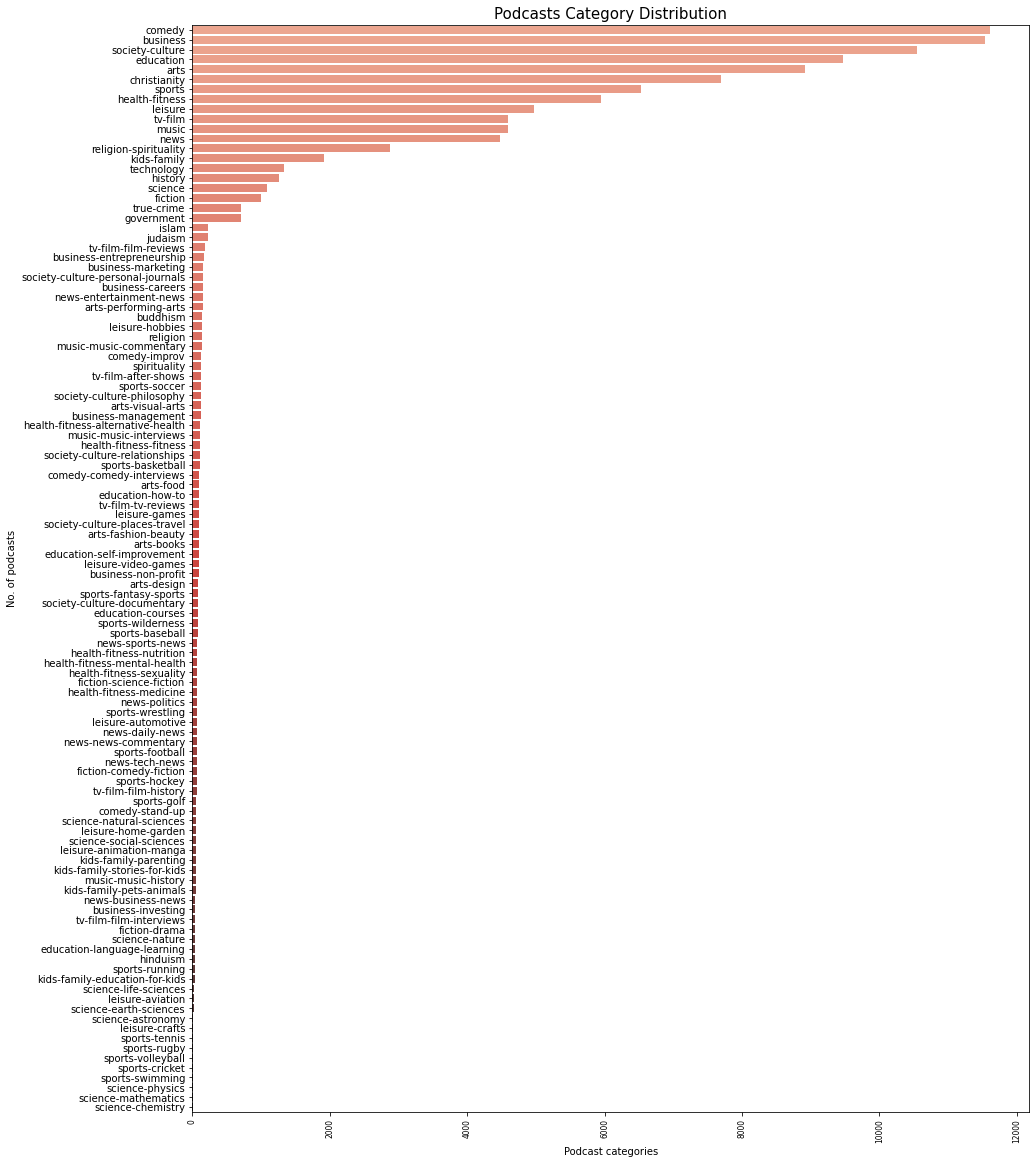

In [13]:
fig = plt.figure(figsize = (15, 20))
podcast_category_val_count = podcasts.category.value_counts()
 
ax = sns.barplot(x=list(podcast_category_val_count),  
                 y=podcast_category_val_count.keys(), palette="Reds_d", orient = 'h')
 
plt.xlabel("Podcast categories")
plt.ylabel("No. of podcasts")
plt.title("Podcasts Category Distribution", fontsize=15)
plt.xticks(rotation = 90, fontsize = 7.5)
plt.show()

We can see that most of the reviews are with rating 5

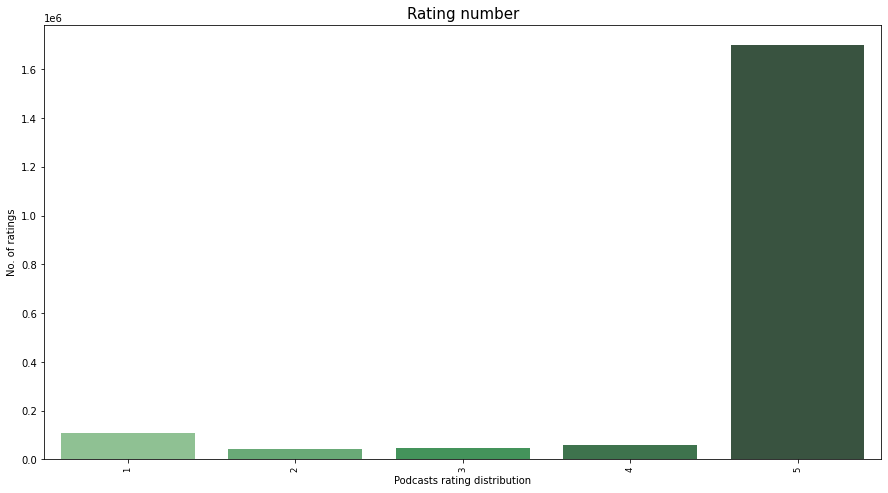

In [14]:
fig = plt.figure(figsize = (15, 8))
reviews_rating_val_count = reviews.rating.value_counts()
 
ax = sns.barplot(x=reviews_rating_val_count.keys(),
                 y=list(reviews_rating_val_count), palette="Greens_d")
 
plt.xlabel("Podcasts rating distribution")
plt.ylabel("No. of ratings")
plt.title("Rating number", fontsize=15)
plt.xticks(rotation = 90, fontsize = 8.5)
plt.show()

In [15]:
reviews_podcast_id_val_count = reviews.podcast_id.value_counts() 

Here I merge podcasts table with number of reviews and average rating table

In [16]:
podcasts = podcasts.merge(podcasts_with_rating_num_and_avg, on='podcast_id')
podcasts.head()

,podcast_id,slug,title,category,reviews_num,rating_avg
0,c61aa81c9b929a66f0c1db6cbe5d8548,backstage-at-tilles-center,Backstage at Tilles Center,arts,2,5.000000
1,ad4f2bf69c72b8db75978423c25f379e,ted-talks-daily,TED Talks Daily,arts,269,3.438662
2,f2970432aad718a000ebac10e48ae6b0,snap-judgment,Snap Judgment,arts,793,4.509458
3,f90b974d49b86b2d4d1769519fb478c0,raging-bullets,Raging Bullets,arts,82,4.560976
4,d9122defb9898145688449f610c8943e,selected-shorts,Selected Shorts,arts,209,4.502392


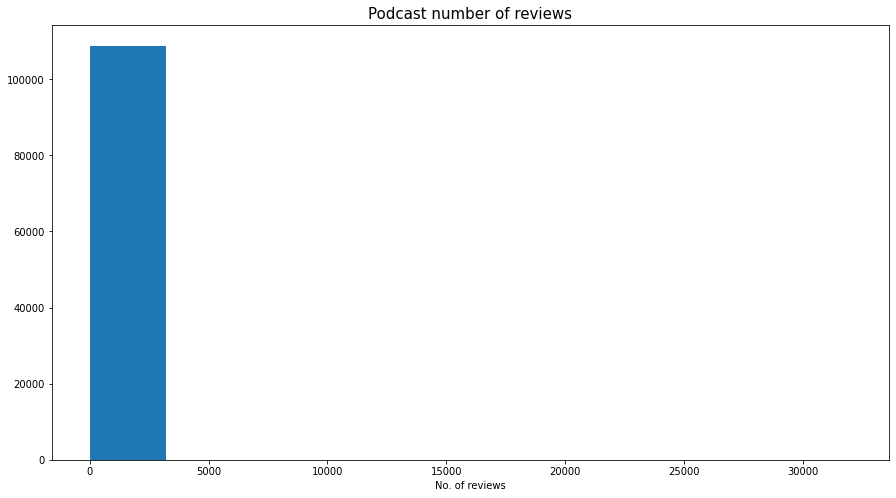

In [17]:
fig = plt.figure(figsize = (15, 8))
plt.hist(list(podcasts['reviews_num']), bins=10)

plt.xlabel("No. of reviews") 
plt.title("Podcast number of reviews", fontsize=15)

plt.show()

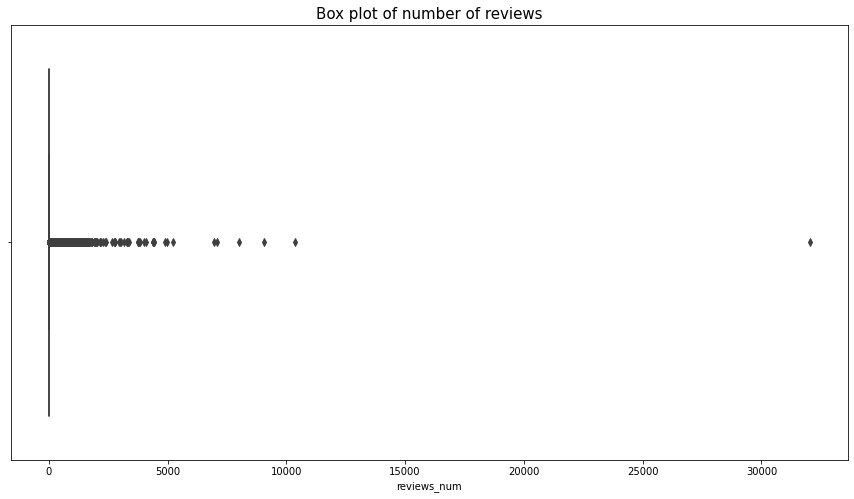

In [18]:
fig = plt.figure(figsize = (15, 8))
sns.boxplot(x=podcasts["reviews_num"])
plt.title('Box plot of number of reviews', fontsize=15) 
plt.show()

We see that dataset has a lot of outliers, therefore, below I remove the outliers with IQR method.

In [19]:
''' Detection '''
# IQR
podcasts_no_outliers = podcasts.copy()
Q1 = np.percentile(podcasts_no_outliers['reviews_num'], 25, interpolation = 'midpoint')

Q3 = np.percentile(podcasts_no_outliers['reviews_num'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", podcasts_no_outliers.shape)

# Upper bound
upper = np.where(podcasts_no_outliers['reviews_num'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(podcasts_no_outliers['reviews_num'] <= (Q1-1.5*IQR))

''' Removing the Outliers '''
podcasts_no_outliers.drop(upper[0], inplace = True)
podcasts_no_outliers.drop(lower[0], inplace = True)

print("New Shape: ", podcasts_no_outliers.shape)


Old Shape:  (108868, 6)
New Shape:  (95082, 6)


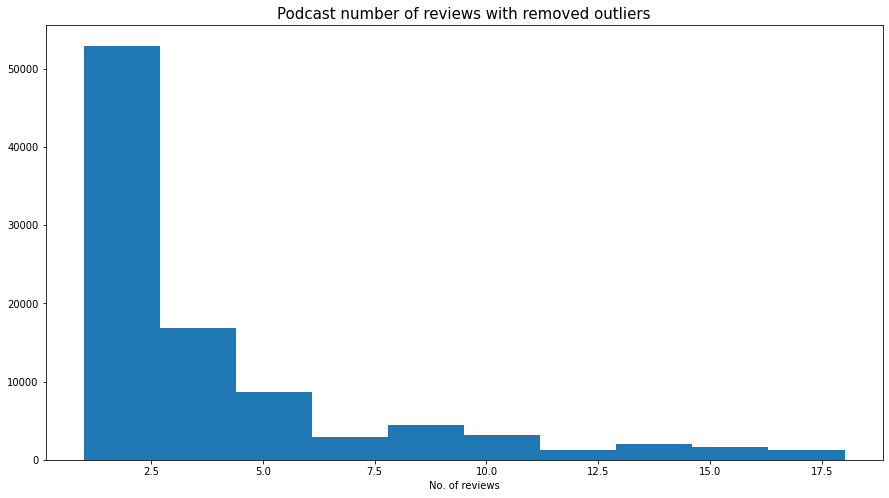

In [20]:
fig = plt.figure(figsize = (15, 8))
plt.hist(list(podcasts_no_outliers['reviews_num']), bins=10)

plt.xlabel("No. of reviews") 
plt.title("Podcast number of reviews with removed outliers", fontsize=15)

plt.show()

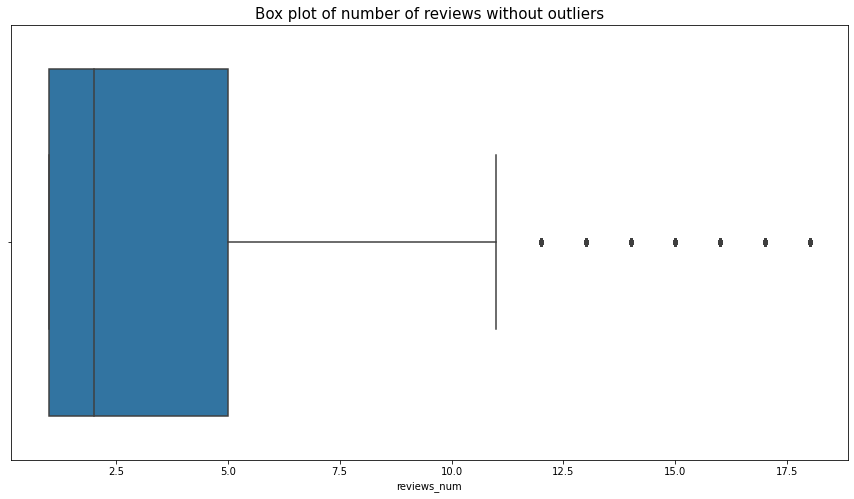

In [21]:
fig = plt.figure(figsize = (15, 8))
sns.boxplot(x=podcasts_no_outliers["reviews_num"])
plt.title('Box plot of number of reviews without outliers', fontsize=15) 
plt.show()

## Category Analysis
The boxplot above depicts top 10 most popular podcast categories. However, it does not say anything about the reviews popularity by category. Therefore, now I will also analyse whether these categories are also most reviewed ones.

### Problem Statement 1
What proportion of reviews that are of category **comedy**

* Population here is All Reviews
* Parameter of Interest is to calculate a Proportion
* Task is to Construct a 95% Confidence Interval for the reviews that are of podcasts with "comedy" category

In [22]:
df = reviews.copy()
n = df.shape[0] 

comedy = df.category.value_counts().loc['comedy']

print("\n95% Confidence Interval for Proportion of reviews with category type 'comedy' is:",
      sm.stats.proportion_confint(comedy, n))


95% Confidence Interval for Proportion of reviews with category type 'comedy' is: (0.1597050791097073, 0.16073308603541062)


**Interpretation:**
* With 95% confidence, the population proportion of reviews with category "comedy" is estimated to be between 15.9% - 16%.

### Problem Statement 2
What proportion of reviews that are of category **business**

* Population here is All Reviews
* Parameter of Interest is to calculate a Proportion
* Task is to Construct a 95% Confidence Interval for the reviews that are of podcasts with "business" category

In [23]:
df = reviews.copy()
n = df.shape[0] 

business = df.category.value_counts().loc['business']

print("\n95% Confidence Interval for Proportion of reviews with category type 'business' is:",
      sm.stats.proportion_confint(business, n))


95% Confidence Interval for Proportion of reviews with category type 'business' is: (0.0991581880543209, 0.0999973779515881)


**Interpretation:**
* With 95% confidence, the population proportion of reviews with category "business" is estimated to be around 9.9%.

### Problem Statement 3
What proportion of reviews that are of category **society-culture**

* Population here is All Reviews
* Parameter of Interest is to calculate a Proportion
* Task is to Construct a 95% Confidence Interval for the reviews that are of podcasts with "society-culture" category

In [24]:
df = reviews.copy()
n = df.shape[0] 

society_culture = df.category.value_counts().loc['society-culture']

print("\n95% Confidence Interval for Proportion of reviews with category type 'society-culture' is:",
      sm.stats.proportion_confint(society_culture, n))


95% Confidence Interval for Proportion of reviews with category type 'society-culture' is: (0.09752454287003369, 0.09835756351229248)


**Interpretation:**
* With 95% confidence, the population proportion of reviews with category "comedy" is estimated to be between 9.7% and 9.8%

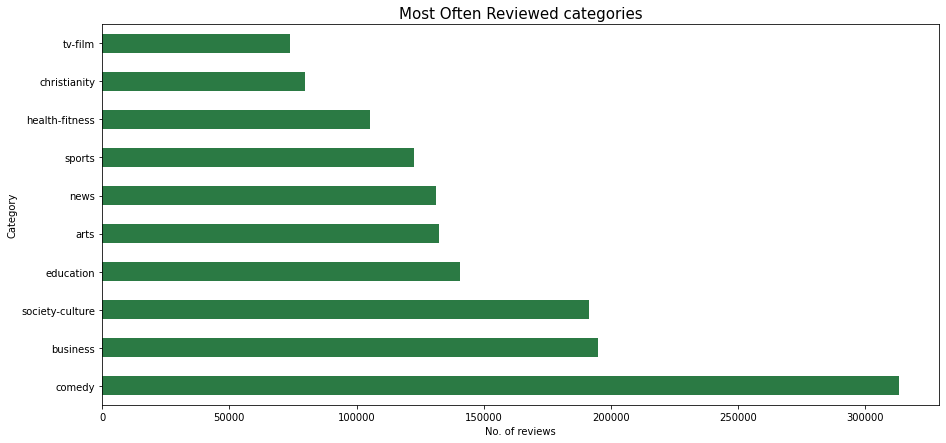

In [25]:
top_10_reviewed_categories = reviews['category'].value_counts()[:10]
top_10_reviewed_categories.plot(kind = 'barh', figsize = (15, 7), color='#2b7a44')

plt.title('Most Often Reviewed categories', fontsize=15) 
plt.xlabel("No. of reviews") 
plt.ylabel("Category") 
plt.show()


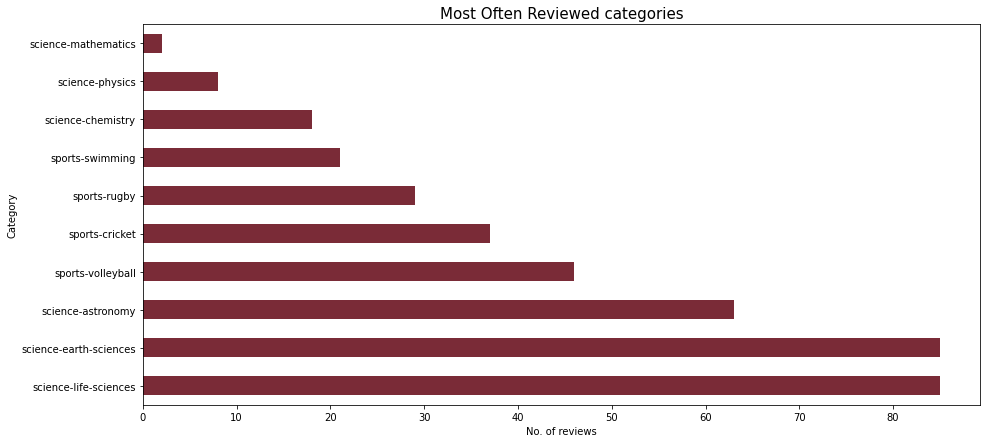

In [26]:
least_10_reviewed_categories = reviews['category'].value_counts()[-10:]
least_10_reviewed_categories.plot(kind = 'barh', figsize = (15, 7), color='#7a2b37')

plt.title('Most Often Reviewed categories', fontsize=15) 
plt.xlabel("No. of reviews") 
plt.ylabel("Category") 
plt.show()

We see that the most of the podcasts are with category 'comedy' and this category is actually also the most popular reviewed one. Therefore in further problems I will examine these top 3 categories.

### Problem Statement 4
What is average number of reviews for podcasts with categories:
* comedy
* business
* society-culture

Let's define a few parameters
* Population here is all reviews
* Parameter of Interest is to calculate a population Mean reviews numbers of podcasts.
* Task is to Construct a 95% C.I. for population mean of number of reviews for all podcasts with selected categories.

In [27]:
df_comedy = podcasts[podcasts['category'] == 'comedy']
conf_int = sm.stats.DescrStatsW(df_comedy['reviews_num']).zconfint_mean()
print(f'''With 95% confidence, the population mean reviews_num for all podcasts with category 'comedy' is estimated to be between {conf_int[0]} and {conf_int[1]}.''') 

With 95% confidence, the population mean reviews_num for all podcasts with category 'comedy' is estimated to be between 23.57678081121016 and 30.454924194389907.


In [28]:
df_business = podcasts[podcasts['category'] == 'business']
conf_int = sm.stats.DescrStatsW(df_business['reviews_num']).zconfint_mean()
print(f'''With 95% confidence, the population mean reviews_num for all podcasts with category 'business' is estimated to be between {conf_int[0]} and {conf_int[1]}.''') 

With 95% confidence, the population mean reviews_num for all podcasts with category 'business' is estimated to be between 15.664001723914273 and 18.10605545854977.


In [29]:
df_soc_culture = podcasts[podcasts['category'] == 'society-culture']
conf_int = sm.stats.DescrStatsW(df_soc_culture['reviews_num']).zconfint_mean()
print(f'''With 95% confidence, the population mean reviews_num for all podcasts with category 'society-culture' is estimated to be between {conf_int[0]} and {conf_int[1]}.''') 

With 95% confidence, the population mean reviews_num for all podcasts with category 'society-culture' is estimated to be between 15.56827435317056 and 20.760762796185013.


### Problem Statement 5
#### Ratings by category

Considering reviews top 3 most popular categories, do these categories differ significantly in mean rating value?

Let us define a few params

* Population here is all reviews with different categories
* Our Parameters of Interest are (μ1 − μ2), (μ1 − μ3) and (μ2 − μ3): rating value
* μ1: Mean rating of reviews with comedy category
* μ2: Mean rating of reviews with business category
* μ3: Mean rating of reviews with society-culture category

There is two approach to calculate mean difference confidence interval:

* Pooled Approach - The variance of the two populations are assumed to be equal for both groups
* Un-pooled approach - The assumption of equal variances is dropped

We need to do some EDA to find out which approach we can use

In [30]:
df.groupby('category').describe()['rating'].transpose().loc[['mean','std'],:]

category,arts,arts-books,arts-design,arts-fashion-beauty,arts-food,arts-performing-arts,arts-visual-arts,buddhism,business,business-careers,...,sports-wilderness,sports-wrestling,technology,true-crime,tv-film,tv-film-after-shows,tv-film-film-history,tv-film-film-interviews,tv-film-film-reviews,tv-film-tv-reviews
mean,4.734168,4.875749,4.913669,4.85843,4.738338,4.596000,4.841983,4.772871,4.840782,4.920160,...,4.759080,4.740583,4.573593,4.243193,4.569662,4.463636,4.842857,4.950237,4.853058,4.676628
std,0.869980,0.580181,0.470280,0.65254,0.843330,1.004982,0.660689,0.770708,0.699579,0.472855,...,0.867168,0.898993,1.078816,1.392431,1.101805,1.210158,0.671286,0.407632,0.680760,0.951280


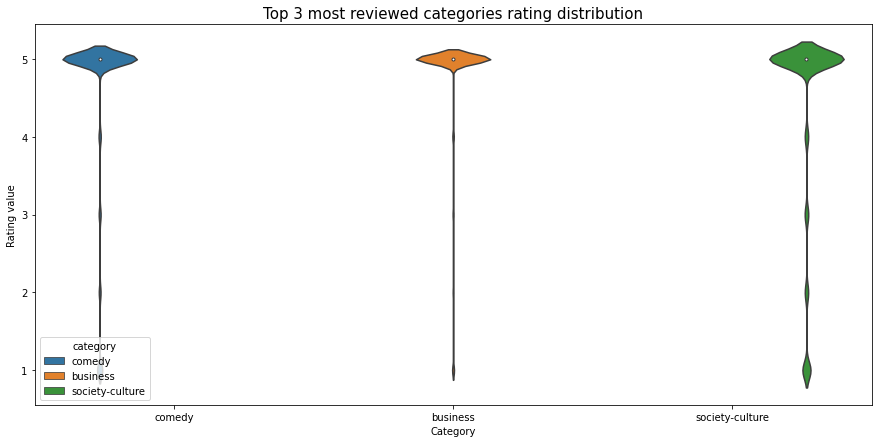

In [31]:
fig = plt.figure(figsize = (15, 7))
top_2_cat_podcasts_reviews = reviews[reviews["category"].isin(['comedy', 'society-culture', 'business'])].sort_values(by='rating')
sns.violinplot(data=top_2_cat_podcasts_reviews, x="category", y="rating", hue="category")

plt.title('Top 3 most reviewed categories rating distribution', fontsize=15) 
plt.xlabel("Category") 
plt.ylabel("Rating value") 
plt.show()

We can see that variance of all categories are nearly similar. Thus I will proceed with Pooled approach.

In [32]:
df_soc_culture_reviews = reviews[reviews["category"] == 'society-culture']
df_comedy_reviews = reviews[reviews["category"] == 'comedy']
df_business_reviews = reviews[reviews["category"] == 'business']

In [33]:
x1 = df_comedy_reviews.rating.mean()
x2 = df_business_reviews.rating.mean()
x3 = df_soc_culture_reviews.rating.mean()

std1 = df_comedy_reviews.rating.std()
std2 = df_business_reviews.rating.std()
std3 = df_soc_culture_reviews.rating.std()

n1 = df_comedy_reviews.shape[0]
n2 = df_business_reviews.shape[0]
n3 = df_soc_culture_reviews.shape[0]

In [34]:
class diffMean:
    import numpy as np
    def __init__(self,x1,x2,std1,std2,n1,n2,t):   
        self.best_estimate1 = x1
        self.best_estimate2 = x2
        self.std1 = std1
        self.std2 = std2
        self.n1 = n1
        self.n2 = n2
        self.t = t
        self.pooled_estimated_se = np.sqrt((np.sqrt(((self.n1-1)*(self.std1**2) +
                                                     (self.n2-1)*(self.std2**2)) / ((self.n1+self.n2)-2))) *
                                           (np.sqrt((1/self.n1)+(1/self.n2))))
         
    def pooledMoe(self):
        return (self.t)*(self.pooled_estimated_se)
    
    def pooledMean(self): 
        return ((self.best_estimate1 - self.best_estimate2) - self.pooledMoe(), 
                (self.best_estimate1 - self.best_estimate2) + self.pooledMoe()) 

In [35]:
mean_diff_x1_x2 = diffMean(x1,x2,std1,std2,n1,n2,1.98) 
print("Best point estimate for (μ1 − μ2): rating value:", (mean_diff_x1_x2.best_estimate1-mean_diff_x1_x2.best_estimate2))
print("95% Confidence Interval for (μ1 − μ2): rating value:", mean_diff_x1_x2.pooledMean(),"\n")

Best point estimate for (μ1 − μ2): rating value: -0.21285253177974983
95% Confidence Interval for (μ1 − μ2): rating value: (-0.31592840499886343, -0.10977665856063623) 



With 95% confidence, the difference in mean rating values between comedy and business podcasts is estimated to be between -0.31592840499886343 and -0.10977665856063623 rating.

In [36]:
mean_diff_x1_x3 = diffMean(x1,x3,std1,std3,n1,n3,1.98) 
print("Best point estimate for (μ1 − μ3): rating value:", (mean_diff_x1_x3.best_estimate1-mean_diff_x1_x3.best_estimate2))
print("Estimated Standard Error for (μ1 − μ3): rating value:", mean_diff_x1_x3.pooled_estimated_se)
print("Margin of Error for (μ1 − μ3): rating value:", mean_diff_x1_x3.pooledMoe())
print("95% Confidence Interval for (μ1 − μ3): rating value:", mean_diff_x1_x3.pooledMean(),"\n")

Best point estimate for (μ1 − μ3): rating value: 0.19868894927948144
Estimated Standard Error for (μ1 − μ3): rating value: 0.05751022674190546
Margin of Error for (μ1 − μ3): rating value: 0.11387024894897281
95% Confidence Interval for (μ1 − μ3): rating value: (0.08481870033050863, 0.31255919822845424) 



With 95% confidence, the difference in mean rating values between comedy and society-culture podcasts is estimated to be between -0.5247698473918976 and -0.29831311472656497 rating.

In [37]:
mean_diff_x2_x3 = diffMean(x2,x3,std2,std3,n2,n3,1.98) 
print("Best point estimate for (μ2 − μ3): rating value:", (mean_diff_x2_x3.best_estimate1-mean_diff_x2_x3.best_estimate2))
print("Estimated Standard Error for (μ2 − μ3): rating value:", mean_diff_x2_x3.pooled_estimated_se)
print("Margin of Error for (μ2 − μ3): rating value:", mean_diff_x2_x3.pooledMoe())
print("95% Confidence Interval for (μ2 − μ3): rating value:", mean_diff_x2_x3.pooledMean(),"\n")

Best point estimate for (μ2 − μ3): rating value: 0.4115414810592313
Estimated Standard Error for (μ2 − μ3): rating value: 0.05718604360235671
Margin of Error for (μ2 − μ3): rating value: 0.1132283663326663
95% Confidence Interval for (μ2 − μ3): rating value: (0.29831311472656497, 0.5247698473918976) 



With 95% confidence, the difference in mean rating values between business and society-culture podcasts is estimated to be between -0.31592840499886343 and -0.10977665856063623 rating.

### Problem Statement 6 - Hyphothesis Testing
Considering business and comedy podcast reviews, do comedy podcasts have higher mean rating value than business podcasts?

Let's define a few parameters:

* Population here is all society-culture and comedy podcast reviews
* Our Parameter of Interest is (μ1 − μ2 ): rating value
* μ1: Mean rating of reviews with comedy category
* μ2: Mean rating of reviews with business category
* Perform an independent samples test regarding the value for the difference in mean rating value between comedy and business podcast reviews


* H₀: μ1≤μ2
* H₁: μ1>μ2 

Significance Level - 5%


In [38]:
df = reviews.copy()
df = df.sample(500000)

In [39]:
df_business_reviews_sampled = df[df["category"] == 'business']
df_comedy_reviews_sampled = df[df["category"] == 'comedy']

Data of both samples is not normally distributed.


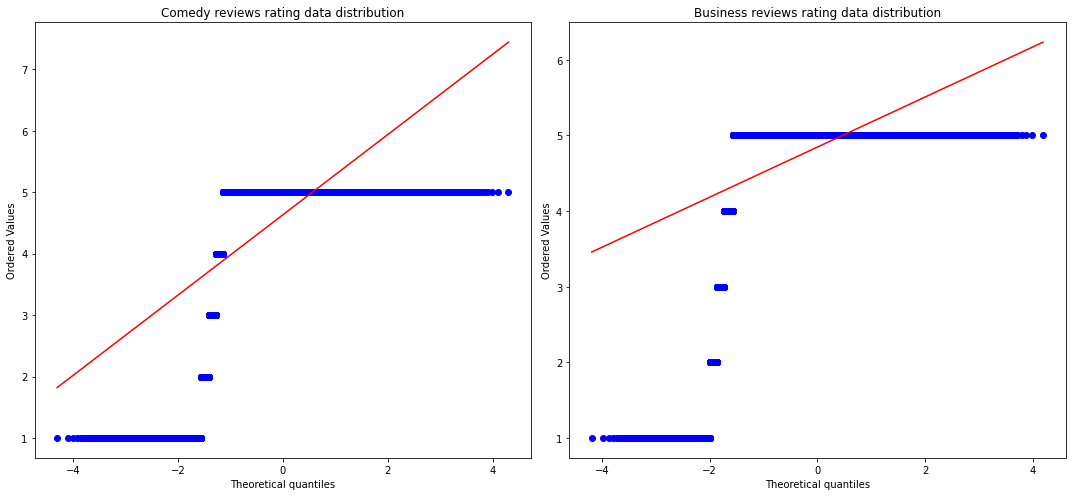

In [40]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_comedy_reviews_sampled.rating, dist='norm', plot=ax3)
ax3.title.set_text('Comedy reviews rating data distribution')

stats.probplot(df_business_reviews_sampled.rating, dist='norm', plot=ax4)
ax4.title.set_text('Business reviews rating data distribution')

fig2.tight_layout()
print("Data of both samples is not normally distributed.")
  
plt.show()

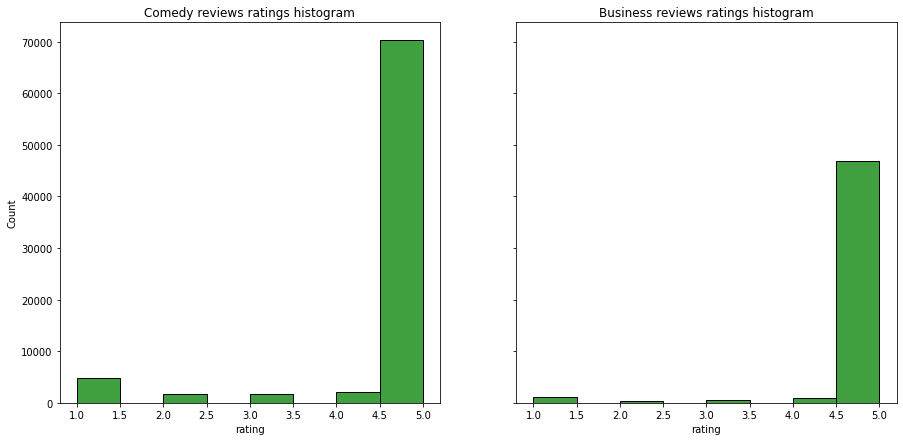

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
 
sns.histplot(ax=axes[0], x=df_comedy_reviews_sampled.rating, color='green',binwidth=0.5)
axes[0].title.set_text('Comedy reviews ratings histogram')

sns.histplot(ax=axes[1], x=df_business_reviews_sampled.rating, color='green',binwidth=0.5)
axes[1].title.set_text('Business reviews ratings histogram')

fig2.tight_layout() 
plt.show()

In [42]:
ttest,p_value = stats.ttest_ind(df_comedy_reviews_sampled.rating, df_business_reviews_sampled.rating)
print("p value:", p_value)
print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 0.0
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 0.0
Reject null hypothesis


T-test interpretation:
* At this significance level, there is enough evidence to conclude that the average rating of the podcasts with comedy category is higher than the podcastrs with business the course asynchronously.

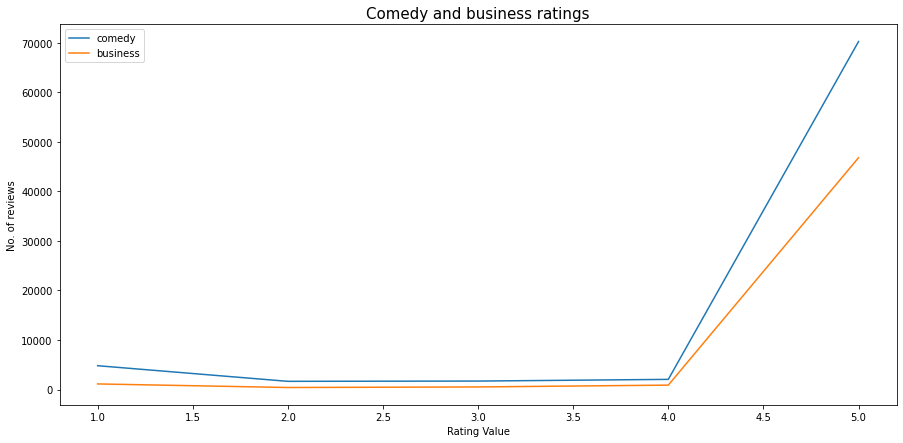

In [43]:
fig = plt.figure(figsize = (15, 7)) 
val_counts_comedy = df_comedy_reviews_sampled.rating.value_counts() 
val_counts_business = df_business_reviews_sampled.rating.value_counts()  
sns.lineplot(x=val_counts_comedy.keys(), y=val_counts_comedy, label="comedy") 
sns.lineplot(x=val_counts_business.keys(), y=val_counts_business, label="business") 

plt.title('Comedy and business ratings', fontsize=15) 
plt.xlabel("Rating Value") 
plt.ylabel("No. of reviews") 
plt.show()

## Rating Analysis

In [44]:
podcasts.sort_values(by='rating_avg', ascending=False).head()

,podcast_id,slug,title,category,reviews_num,rating_avg
0,c61aa81c9b929a66f0c1db6cbe5d8548,backstage-at-tilles-center,Backstage at Tilles Center,arts,2,5.0
69053,be55a8901630687ee97eb40f020cfcb2,%EC%95%84%EB%A9%94%EB%A6%AC%EC%B9%B4%EB%85%B8,아메리카노,news-news-commentary,21,5.0
69062,be5839f37bddb1aecfdb36e7971cd0e9,diabuddies-podcast,Diabuddies Podcast,health-fitness,1,5.0
69061,be5831c4fd81876994a7171a14e4c113,biz-talks,Biz Talks,business,3,5.0
69060,be57c48eeb29e6f77bcf1b7e50402197,breaking-balance,Breaking Balance,business,1,5.0


In [45]:
podcasts.sort_values(by='reviews_num', ascending=False).head()

,podcast_id,slug,title,category,reviews_num,rating_avg
14541,bf5bf76d5b6ffbf9a31bba4480383b7f,crime-junkie,Crime Junkie,true-crime,32028,4.285969
5179,bc5ddad3898e0973eb541577d1df8004,my-favorite-murder-karen-kilgariff-georgia-har...,My Favorite Murder with Karen Kilgariff and Ge...,comedy,10352,3.622585
11163,bad6c91efdbee814db985c7a65199604,wow-in-the-world,Wow in the World,education,9047,4.776390
11997,f5fce0325ac6a4bf5e191d6608b95797,the-ben-shapiro-show,The Ben Shapiro Show,news,8009,3.816581
12019,b1a3eb2aa8e82ecbe9c91ed9a963c362,true-crime-obsessed,True Crime Obsessed,society-culture,7085,4.231898


In [46]:
podcasts.sort_values(["reviews_num", "rating_avg"],
               axis = 0, ascending = False,
               inplace = True,
               na_position = "first") 
sorted_podcasts = podcasts
sorted_podcasts[sorted_podcasts['rating_avg'] >= 4.9].head(10)

,podcast_id,slug,title,category,reviews_num,rating_avg
42988,e6568415fd1b0c32cbefbb4cb6dc78d2,know-your-aura-with-mystic-michaela,Know Your Aura with Mystic Michaela,education,4966,4.983488
5235,c8bde52bde033bac86f0892998f7c062,crime-in-sports,Crime in Sports,comedy,4890,4.931288
13772,e6dc31392a05c976072c9aa83b27f567,ologies-with-alie-ward,Ologies with Alie Ward,comedy,3831,4.910467
2918,e4f40593687b648068b986ad01bacb7d,dont-keep-your-day-job,Don't Keep Your Day Job,business,3057,4.938829
5543,c2f3608087c2d9109b0f76a42ce880cb,daebak-show-w-eric-nam,Daebak Show w/ Eric Nam,music,2967,4.984159
9315,b5c350c463c787b2b02204029bfc0885,the-mindset-mentor,The Mindset Mentor,health-fitness,2277,4.905578
12391,f529487b091b7659049b17420ae20267,highest-self-podcast,Highest Self Podcast,health-fitness,2169,4.924389
17872,f0dfffcf31bf20de0dd3cc7a0faaf723,the-weekly-planet,The Weekly Planet,tv-film,1830,4.940984
17906,d55e7cf6f53368e69bb466d2e7e73faf,fantastic-geeks,Fantastic Geeks,tv-film,1617,4.951763
9356,eb31bc4c8bf332569e5697d3166a4fec,manifestation-babe,Manifestation Babe,education,1581,4.930424


In [47]:
podcasts.sort_values(["reviews_num", "rating_avg"],
               axis = 0, ascending = False,
               inplace = True,
               na_position = "first") 
sorted_podcasts = podcasts
sorted_podcasts[sorted_podcasts['rating_avg'] < 3.3].head(10)

,podcast_id,slug,title,category,reviews_num,rating_avg
11994,bede69aae211565459aceb5f7e8155d3,pod-save-america,Pod Save America,news,3351,3.283796
420,d739564fca425b41c8c785d82ec64c18,off-the-vine-with-kaitlyn-bristowe,Off The Vine with Kaitlyn Bristowe,society-culture,1990,3.286935
17866,ce295a06b5c7d06a1d123cdc66fb70c7,the-ben-and-ashley-i-almost-famous-podcast,The Ben and Ashley I Almost Famous Podcast,tv-film,1933,2.758407
16271,ce8f9cd50a43a3d46302f8fcebf40a3e,the-fighter-the-kid,The Fighter & The Kid,sports,1790,2.782123
16270,c4cc8397589a079425c03a04eafab41a,fantasy-focus-football,Fantasy Focus Football,sports,1439,3.289785
12029,c787e85061615f1896b5f51acd0fbb56,cold-case-files,Cold Case Files,society-culture,1264,2.951741
16277,b194e46279d6db1e61616039783f1b26,skip-and-shannon-undisputed,Skip and Shannon: Undisputed,news,873,3.232532
12005,c684ea6c24f8a6a16c18edd37f2aea41,undisclosed,Undisclosed,news,856,3.179907
11067,c0e0dcd041db64885fdbc0aab607c389,mommies-tell-all,Mommies Tell All,kids-family,814,3.144963
12018,c4eafea85540de95544b73777e19c696,the-sean-hannity-show,The Sean Hannity Show,news,788,3.177665


### Problem Statement 7 - Hyphothesis Testing
Considering education and comedy podcast reviews, do education podcasts have higher mean rating value than comedy podcasts?

Let's define a few parameters:

* Population here is sample of 500000 reviews
* Our Parameter of Interest is (μ1 − μ2): rating value
* μ1: Mean rating of reviews with education category
* μ2: Mean rating of reviews with comedy category
* Perform an independent samples test regarding the value for the difference in mean rating value between education and comedy podcast reviews


* H₀: μ1≤μ2
* H₁: μ1>μ2

Significance Level - 5%

In [48]:
df = reviews.copy()
df = df.sample(500000)

In [49]:
df_education_reviews_sampled = df[df["category"] == 'education']
df_comedy_reviews_sampled = df[df["category"] == 'comedy']

The data is not normally distributed.


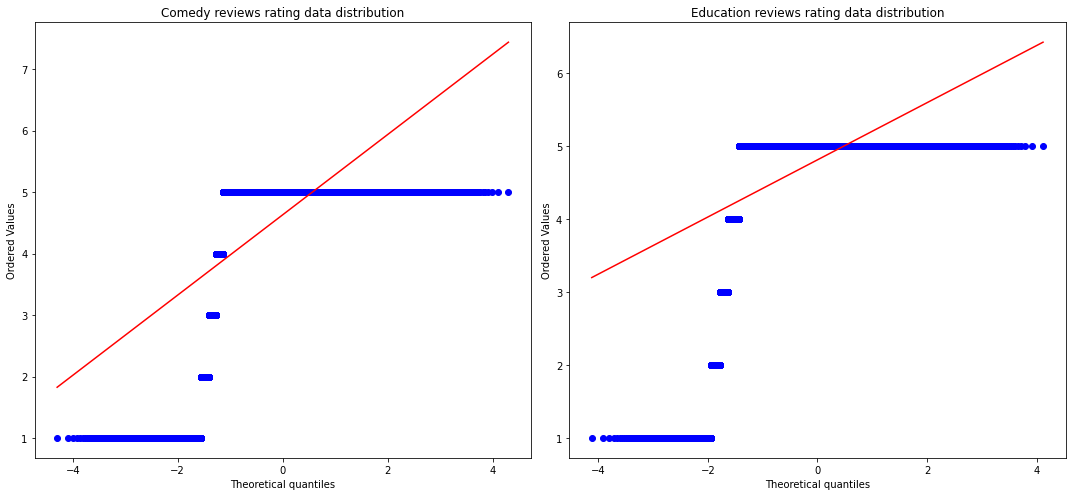

In [50]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_education_reviews_sampled.rating, dist='norm', plot=ax4)
ax4.title.set_text('Education reviews rating data distribution')

stats.probplot(df_comedy_reviews_sampled.rating, dist='norm', plot=ax3)
ax3.title.set_text('Comedy reviews rating data distribution')

fig2.tight_layout()
print("The data is not normally distributed.")
plt.show()

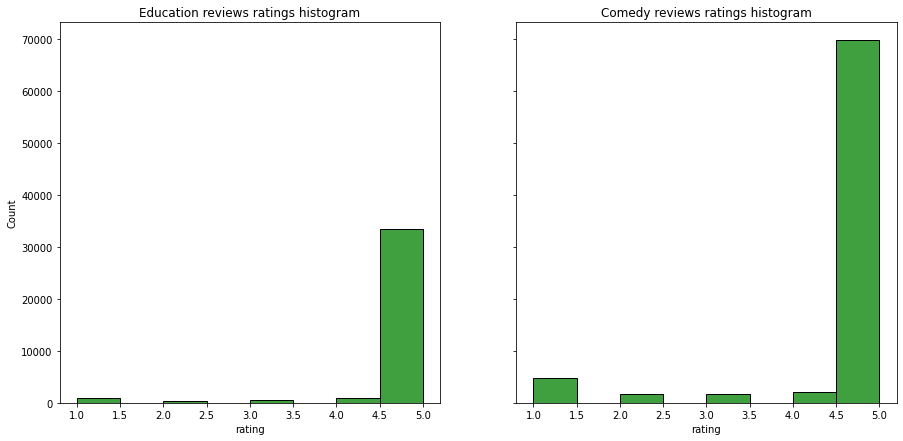

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
 
sns.histplot(ax=axes[0], x=df_education_reviews_sampled.rating, color='green',binwidth=0.5)
axes[0].title.set_text('Education reviews ratings histogram')

sns.histplot(ax=axes[1], x=df_comedy_reviews_sampled.rating, color='green',binwidth=0.5)
axes[1].title.set_text('Comedy reviews ratings histogram')

fig2.tight_layout() 
plt.show() 

In [52]:
ttest,p_value = stats.ttest_ind(df_comedy_reviews_sampled.rating, df_education_reviews_sampled.rating)
print("p value:", p_value)
print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 6.982611613898575e-182
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 3.4913058069492877e-182
Reject null hypothesis


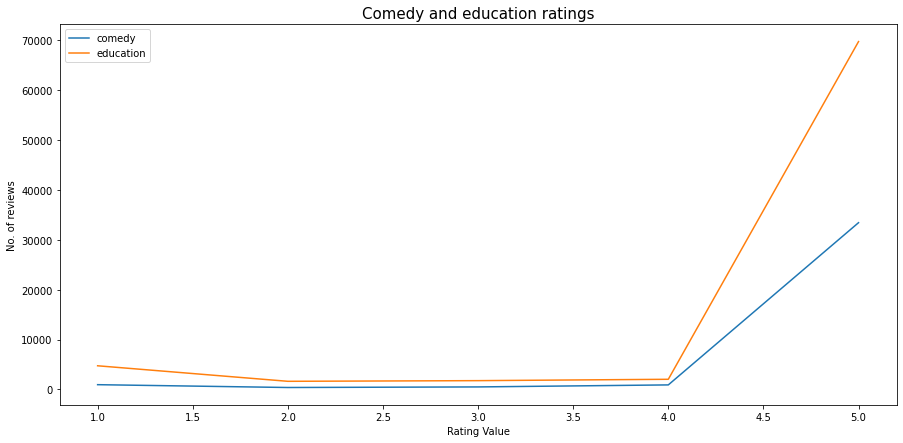

In [53]:
fig = plt.figure(figsize = (15, 7)) 
val_counts_comedy = df_education_reviews_sampled.rating.value_counts() 
val_counts_education = df_comedy_reviews_sampled.rating.value_counts()  
sns.lineplot(x=val_counts_comedy.keys(), y=val_counts_comedy, label="comedy") 
sns.lineplot(x=val_counts_education.keys(), y=val_counts_education, label="education") 

plt.title('Comedy and education ratings', fontsize=15) 
plt.xlabel("Rating Value") 
plt.ylabel("No. of reviews") 
plt.show()

## Podcast Analysis by Year

In [54]:
reviews['created_at'] = pd.to_datetime(reviews['created_at'])  

In [55]:
reviews_2018 = reviews[reviews['created_at'].dt.year == 2018]
reviews_2019 = reviews[reviews['created_at'].dt.year == 2019]
reviews_2020 = reviews[reviews['created_at'].dt.year == 2020]
reviews_2021 = reviews[reviews['created_at'].dt.year == 2021]
reviews_2022 = reviews[reviews['created_at'].dt.year == 2022]

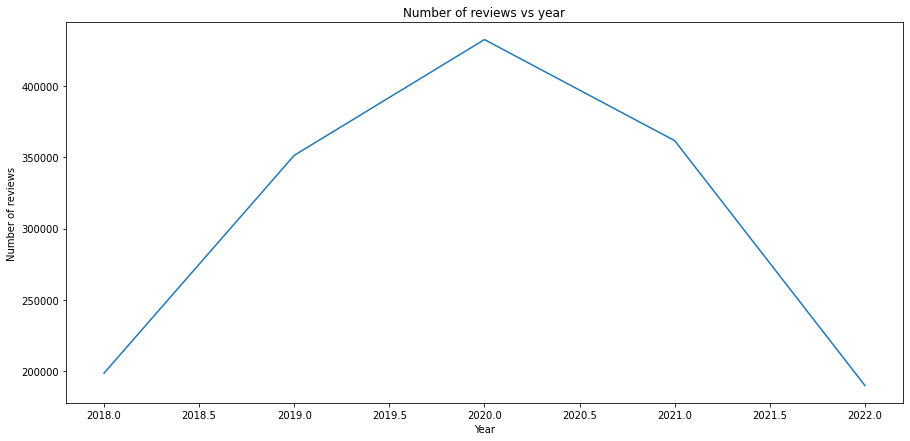

In [56]:
fig = plt.figure(figsize = (15, 7)) 
years = [2018, 2019, 2020, 2021, 2022]
vals = [len(reviews_2018), len(reviews_2019), len(reviews_2020), len(reviews_2021), len(reviews_2022)]

plt.plot(years, vals)
plt.title('Number of reviews vs year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.show() 

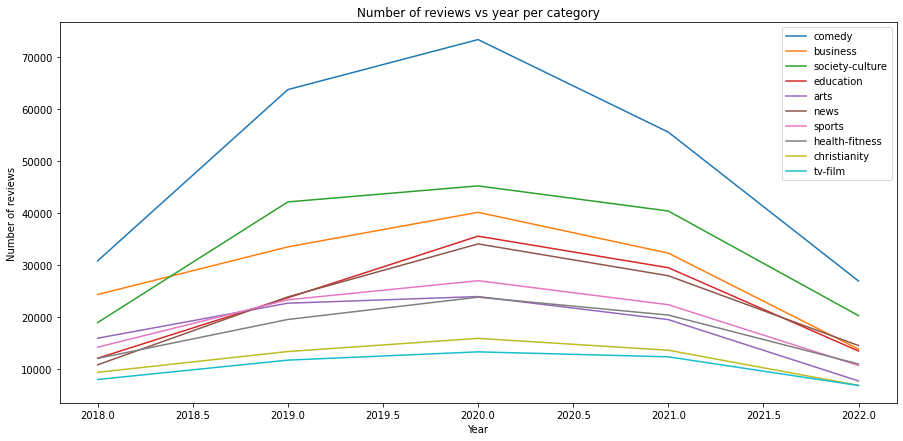

In [57]:
fig = plt.figure(figsize = (15, 7)) 
years = [2018, 2019, 2020, 2021, 2022]

for cat in top_10_reviewed_categories.keys():
    vals_category = [len(reviews_2018[reviews_2018['category'] == cat]),
                     len(reviews_2019[reviews_2019['category'] == cat]),
                     len(reviews_2020[reviews_2020['category'] == cat]), 
                     len(reviews_2021[reviews_2021['category'] == cat]), 
                     len(reviews_2022[reviews_2022['category'] == cat])]
    
    plt.plot(years, vals_category, label=cat)

plt.title('Number of reviews vs year per category')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.legend(loc="upper right")
plt.show() 

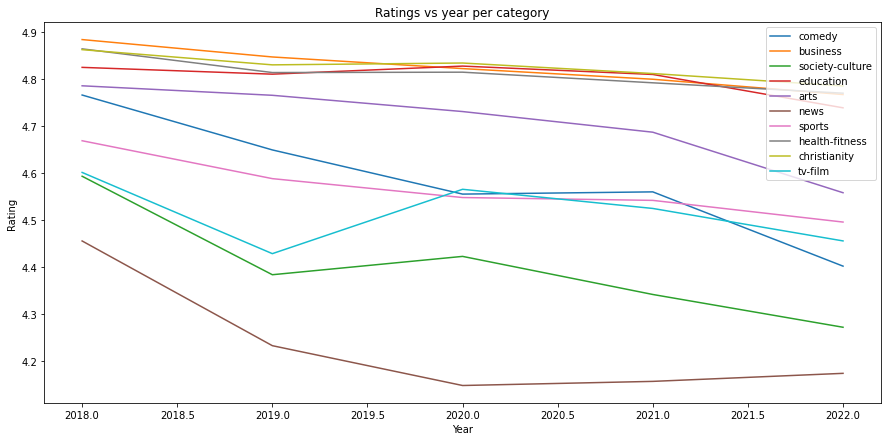

In [58]:
fig = plt.figure(figsize = (15, 7)) 
 
for cat in top_10_reviewed_categories.keys():
    mean_rating = [reviews_2018[reviews_2018['category'] == cat]['rating'].mean(),
                   reviews_2019[reviews_2019['category'] == cat]['rating'].mean(),
                   reviews_2020[reviews_2020['category'] == cat]['rating'].mean(),
                   reviews_2021[reviews_2021['category'] == cat]['rating'].mean(),
                   reviews_2022[reviews_2022['category'] == cat]['rating'].mean()]
    
    plt.plot(years, mean_rating, label=cat)

plt.title('Ratings vs year per category')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend(loc="upper right")
plt.show()  

## Number of reviews and average rating correlation test

Pearson correlation = -0.03842191920791119


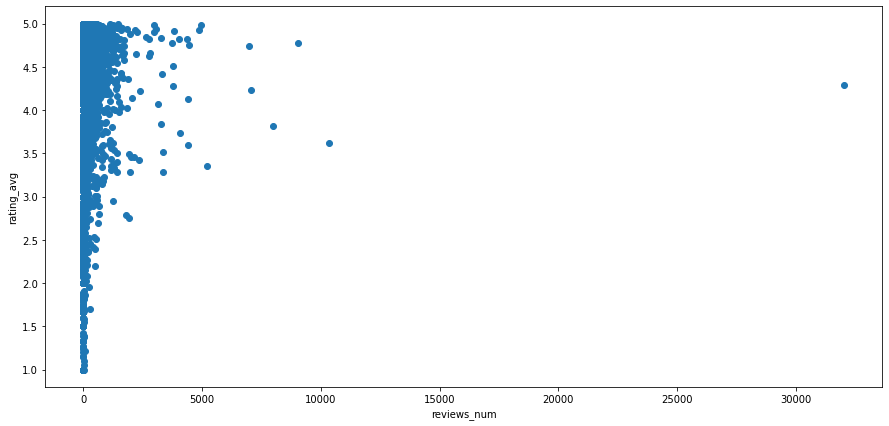

In [59]:
_ = plt.figure(figsize=(15,7))
_ = plt.scatter(x=podcasts['reviews_num'], y=podcasts['rating_avg']);
_ = plt.xlabel('reviews_num')
_ = plt.ylabel('rating_avg')
 
obs_corr = podcasts[['reviews_num', 'rating_avg']].corr().iloc[0, 1]
print("Pearson correlation =", obs_corr)

In [60]:
def replicate(data1,data2,stat=np.corrcoef):
    rep=np.empty(1000)
    for i in range(1000):
        inds=np.random.choice(a=data1.index,size=len(data1),
                          replace=True)
        rep[i]=stat(data1.loc[inds],data2.loc[inds])[0,1]
    return(rep)

In [61]:
corr_resamp=replicate(podcasts['rating_avg'], podcasts['reviews_num'])
np.percentile(corr_resamp, [2.5,97.5]).round(3)

array([-0.054, -0.029])

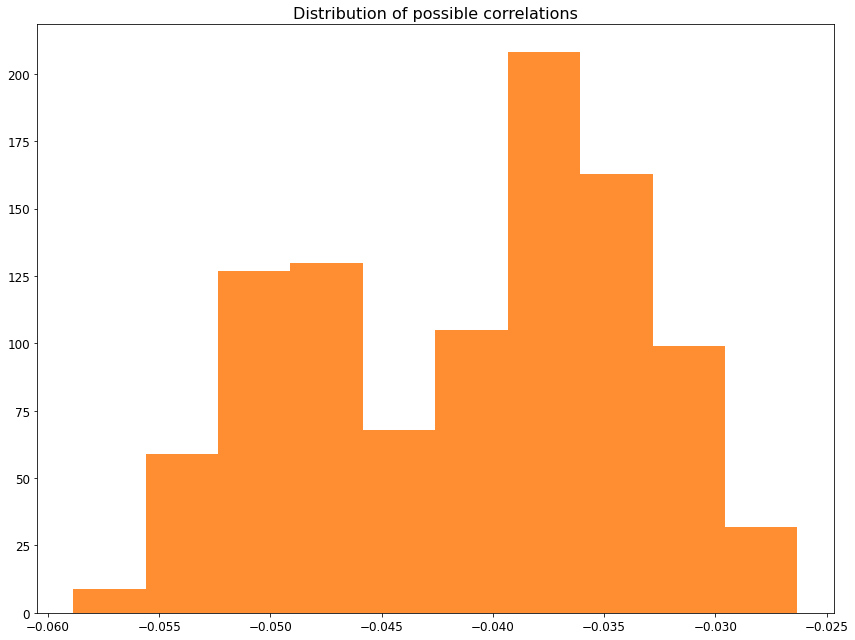

In [62]:
# Creating the figure size
plt.figure(figsize=(12,9))
# Plotting the histogram
_=plt.hist(corr_resamp,color='#FF8E33')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of possible correlations',fontsize=16)
# Creating the annotation for the figure
plt.annotate('Low 95 CI',(0.679,0),xytext=(0.679,100),arrowprops=dict(facecolor='black'),fontsize=12)
plt.annotate('High 95 CI',(0.697,0),xytext=(0.697,100),arrowprops=dict(facecolor='black'),fontsize=12)
#Exporting the image
plt.tight_layout()

Therefore, it is possible to conclude that the correlation observed is random, does not exist and should not be taken into consideration.

## Rating Content Analysis

In [63]:
all_reviews = list(reviews['content'])
all_reviews = " ".join(all_reviews).lower() 
all_reviews = all_reviews.split(" ")

In [64]:
c = Counter(all_reviews)
most_occur = c.most_common(2000)
all_reviews = [x[0] for x in most_occur] 

In [65]:
sw_nltk = stopwords.words('english')

In [66]:
all_reviews = [q for q in all_reviews if (q not in sw_nltk and len(q) > 3 and q.isalpha())]
all_reviews = " ".join(all_reviews) 

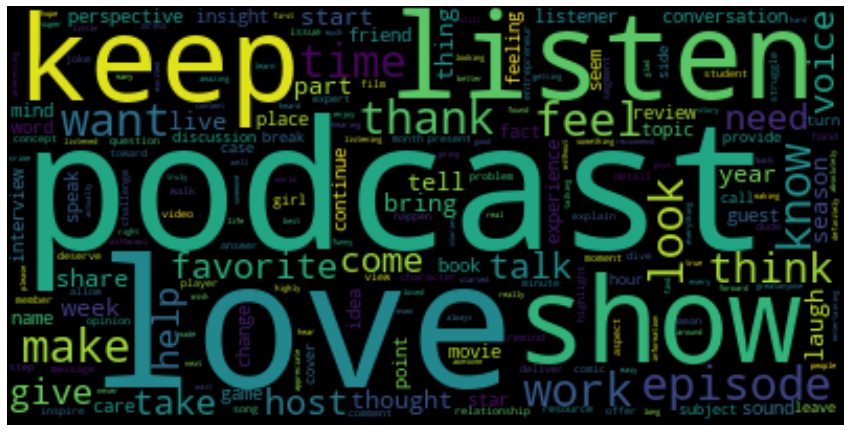

In [67]:
plt.figure(figsize=(15,12))
wordcloud = WordCloud().generate(all_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()  

# Conclusions

* There are the most podcasts with categories: 1) comedy 2) business 3) society-culture;
* The most reviewed categories are: 1) comedy 2) business 3) society-culture;
* The least reviewed categories are: 1) science-mathematics 2) science-physics 3) science-chemistry;
* Most of the reviews are with ranking 5
* The most popular podcast is “Crime Junkie” with 32028 reviews and average rating of 4.28
* The best reviewed podcast (taking into account the number of reviews) is “Know Your Aura with Mystic Michaela” with “education” category and 4966 number of reviews and average rating 4.983
* The worst reviewed podcast (taking into account the number of reviews) is Pod Save America which is with category “news” and has average rating of 3.28
* Number of reviews reached it’s peek in year 2020 and then it was gradually decreasing overtime. And the same happened for all top 10 most reviewed categories.
* The average rating of reviews also decreased overtime.
* The number of reviews and average rating did not have any correlation.